# Network Analysis

In this notebook, we will investigate the network between the authors of the articles.

## 1. Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from collections import Counter
from itertools import combinations

## 2. Loading data

In [2]:
df = pd.read_parquet(r"..\Data\cleaned_parquet\final\P5_final_new.parquet")
df.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,...,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf,disease_abstract_spacy,disease_title_spacy,disease_mesh_terms_spacy
0,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,...,"[[CLS], potential, impact, health, care, refor...","[general, article, observes, despite, clear, p...","[[CLS], general, article, observes, despite, c...",[hiv],[hiv],"[hiv, aids]","[hiv, aids]","[human immunodeficiency virus (HIV) disease, a...",[],[HIV Infections]
1,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,...,"[[CLS], new, jersey, health, promotion, diseas...","[general, health, promotion, major, component,...","[[CLS], general, health, promotion, major, com...",[],[],[],[],[],[],[]
2,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,...,"[[CLS], provide, prevent, ##ive, services, ?, ...","[general, health, care, reform, united, states...","[[CLS], general, health, care, reform, united,...",[],[],[],[],[],[],[]
3,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,...,"[[CLS], cy, ##tore, ##duction, small, int, ##e...","[general, cavitron, ultrasonic, surgical, aspi...","[[CLS], general, ca, ##vi, ##tron, ultra, ##so...",[],[],[tumor],[tumor],"[carcinoma of the ovary, and one each had, tub...",[],"[Adenocarcinoma, Neoplasms, Ovarian Neoplasms]"
4,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,...,"[[CLS], racial, differences, access, kidney, t...","[general, previous, work, documented, large, d...","[[CLS], general, previous, work, documented, l...",[],[],[],[],"[renal failure, renal failure, end stage renal...",[],[American Kidney Failure]


In [10]:
df.columns

Index(['uid', 'title', 'journal', 'abstract', 'authors', 'affiliations',
       'mesh_terms', 'keywords', 'coi_statement', 'parsed_date',
       'cleaned_title_tokens_simple', 'cleaned_title_tokens_hf',
       'cleaned_abstract_tokens_simple', 'cleaned_abstract_tokens_hf',
       'disease_title_tokens_simple', 'disease_title_tokens_hf',
       'disease_abstract_tokens_simple', 'disease_abstract_tokens_hf',
       'disease_abstract_spacy', 'disease_title_spacy',
       'disease_mesh_terms_spacy'],
      dtype='object')

### 3. Top 10 Authors

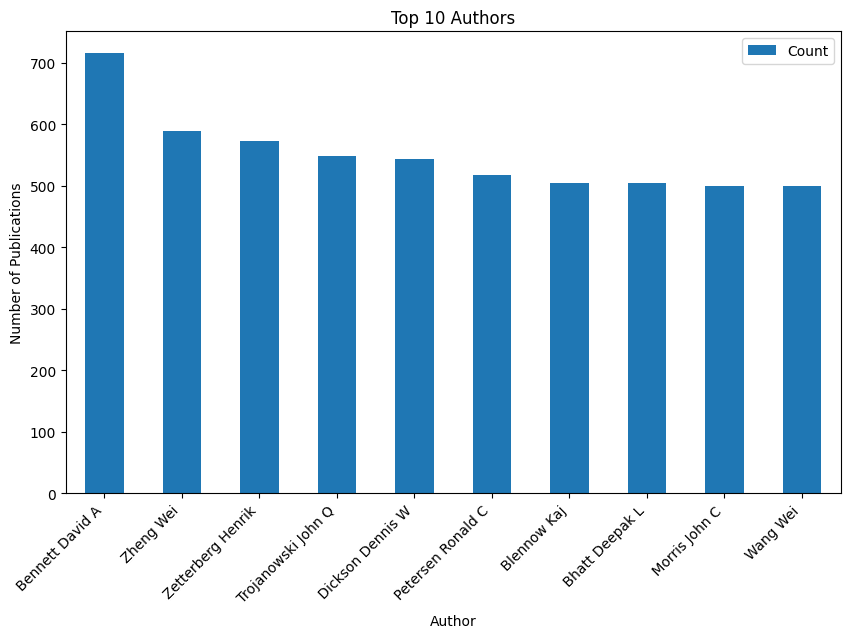

In [4]:
all_authors = df['authors'].str.split(';').explode()

author_counts = Counter(all_authors)

top_authors = author_counts.most_common(10)

top_authors_df = pd.DataFrame(top_authors, columns=['Author', 'Count'])

top_authors_df.plot(kind='bar', x='Author', y='Count', figsize=(10, 6), title='Top 10 Authors')
plt.xlabel('Author')

plt.ylabel('Number of Publications')
plt.xticks(rotation=45, ha='right')
plt.show()

As we can see, the top publisher in our dataset is David A. Bennett [1], who has a little more than 700 filtered articles with diseases. In his Google Scholar profile, he has 1195 articles in total.

## 4. Co-Authorship Network Graph

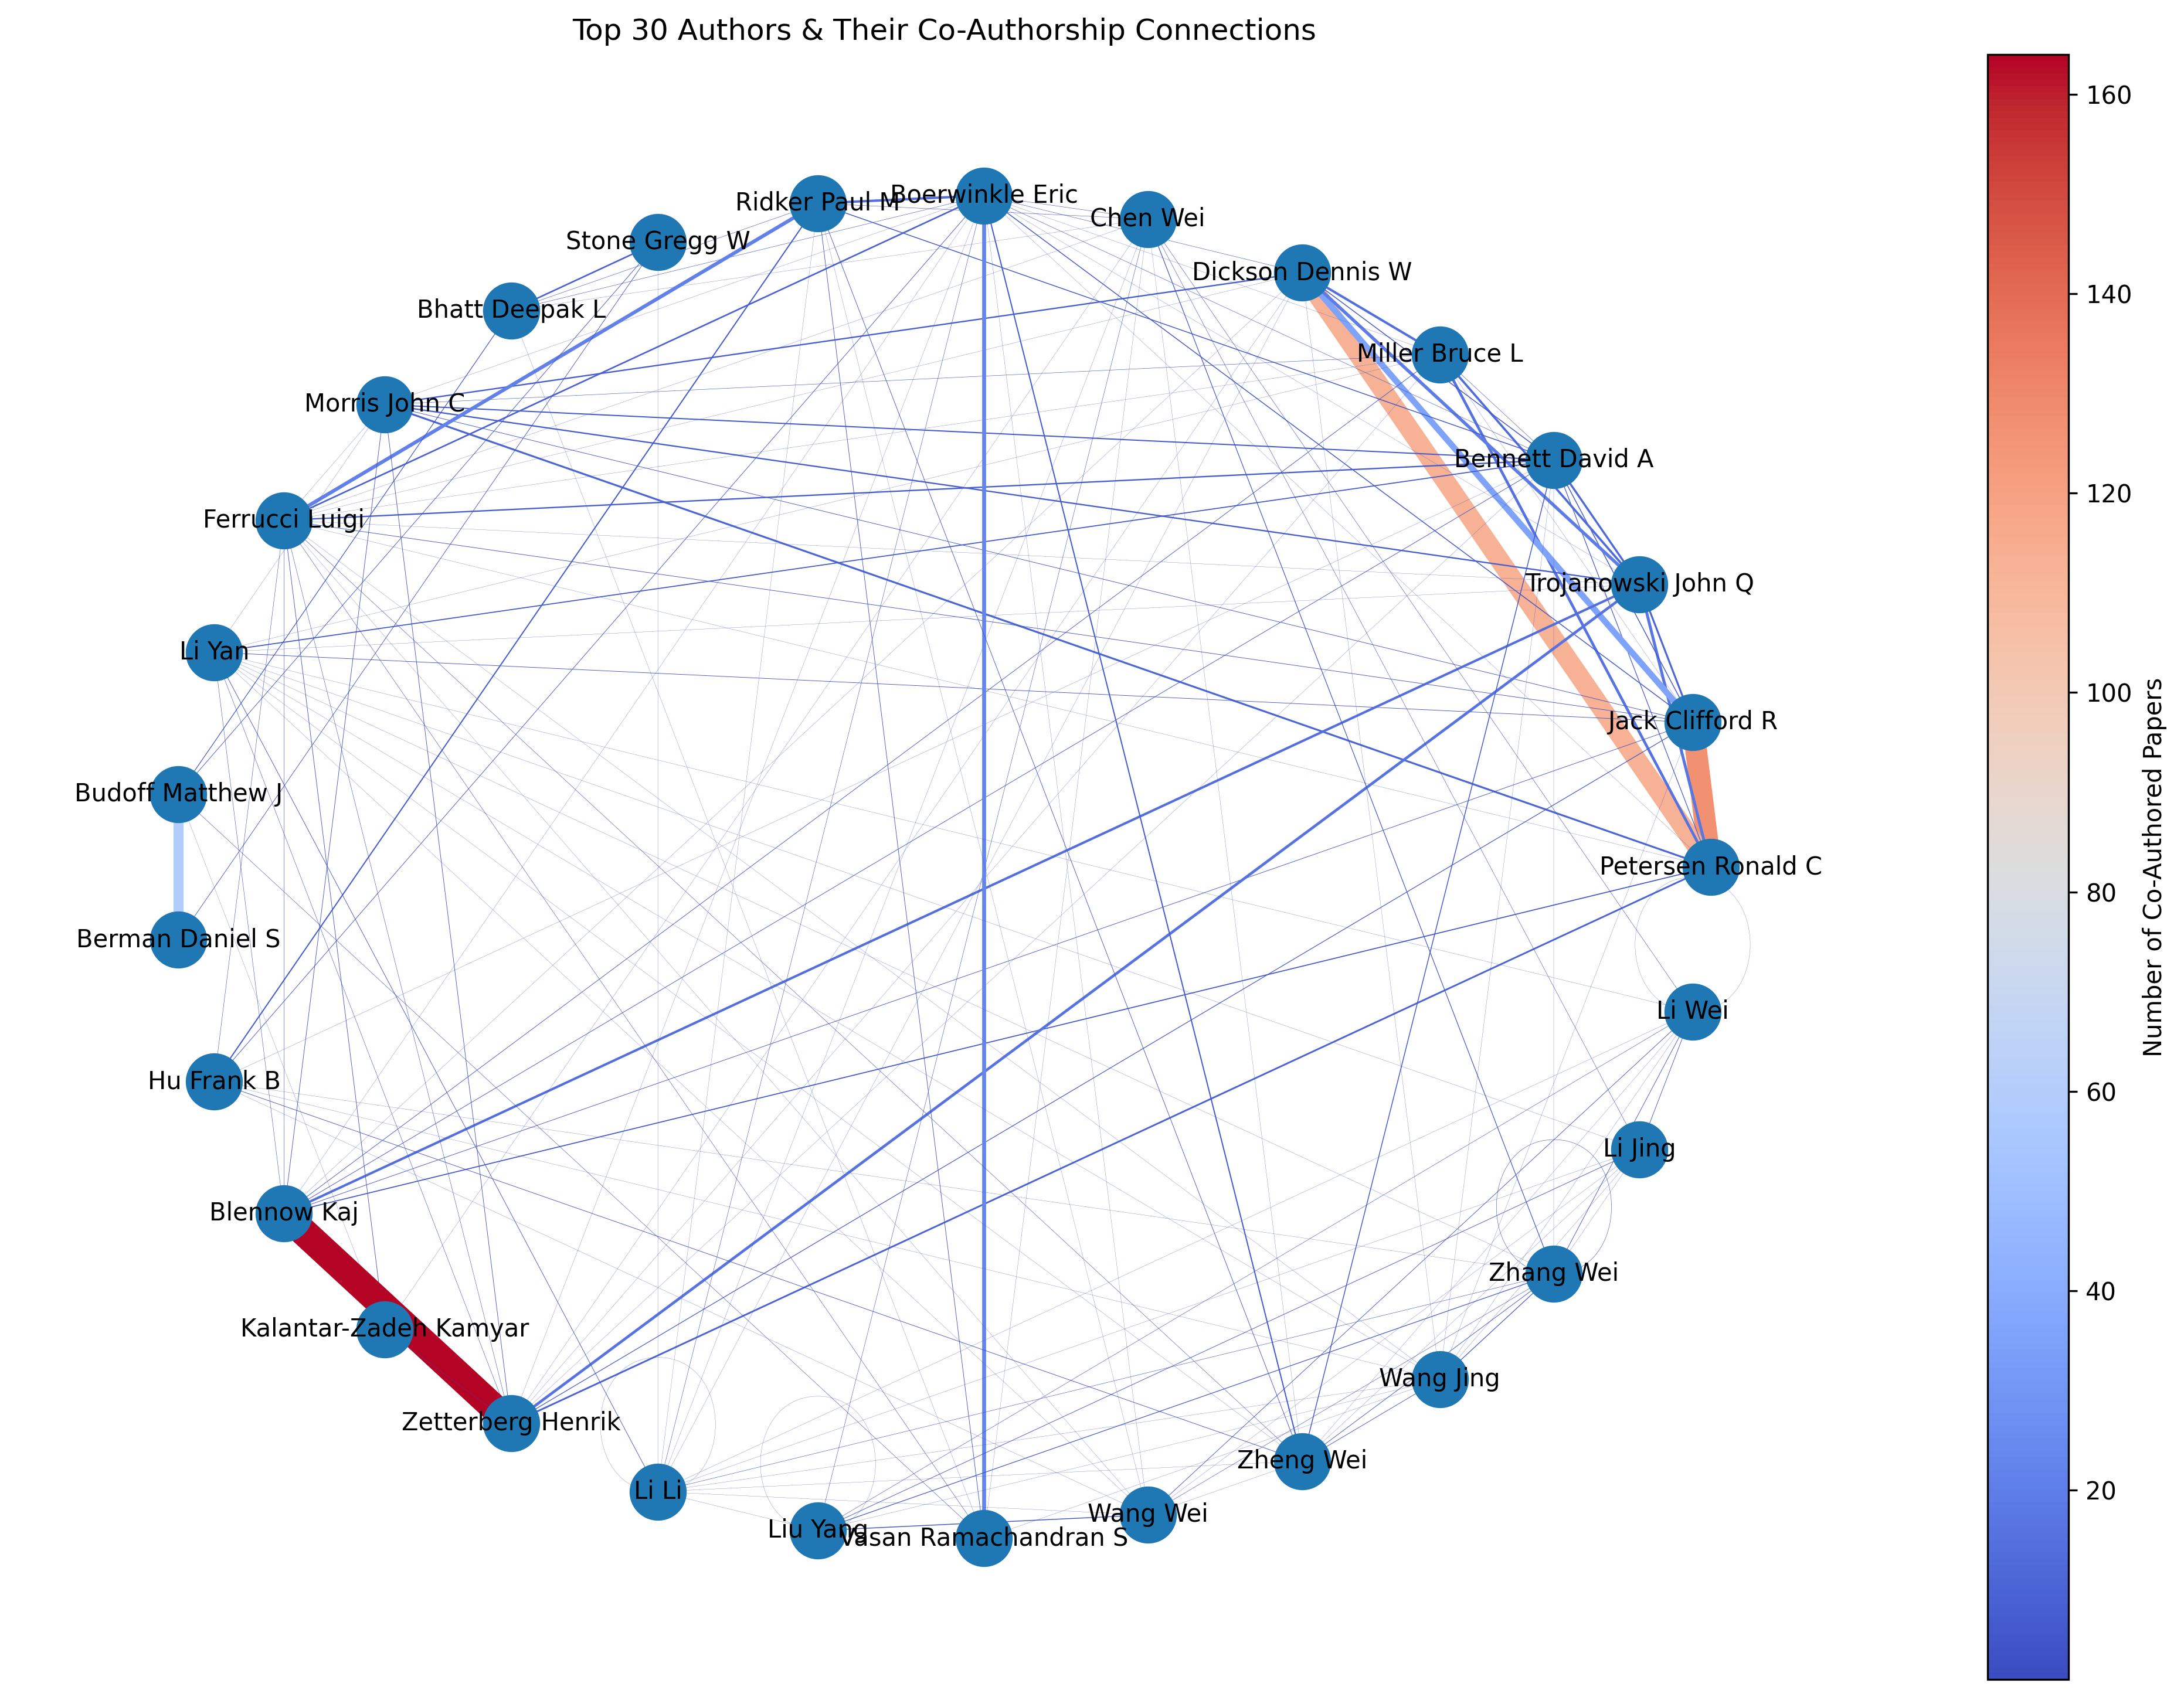

In [ ]:
df['author_list'] = df['authors'].str.split('; ')

co_authorships = Counter()
for authors in df['author_list'].dropna():
    for pair in combinations(authors, 2):  
        co_authorships[pair] += 1

author_counts = Counter([author for authors in df['author_list'].dropna() for author in authors])
top_authors = {author for author, _ in author_counts.most_common(30)}

filtered_edges = [(a, b, w) for (a, b), w in co_authorships.items() if a in top_authors and b in top_authors]

G_authors = nx.Graph()
G_authors.add_weighted_edges_from(filtered_edges)

fig, ax = plt.subplots(figsize=(17, 12), dpi=300)
pos = nx.circular_layout(G_authors)  # Use circular layout

weights = [data['weight'] for _, _, data in G_authors.edges(data=True)]
scaled_weights = [w * 0.07 for w in weights]  

norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = plt.cm.coolwarm
edge_colors = [cmap(norm(w)) for w in weights]

nx.draw(
    G_authors, pos, with_labels=True, node_size=500, font_size=10,
    width=scaled_weights, edge_color=edge_colors, ax=ax
)
plt.title("Top 30 Authors & Their Co-Authorship Connections")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="Number of Co-Authored Papers")

plt.show()

The graph above represents the top 30 authors and their co-authorship connections. We can observe strong connections between some of them. 

For example, Blennow Kaj and Zetterberg Henrik have co-authored around 160 articles together.

Additionally, some authors like Li Li or Liu Yang appear to have connections to themselves. Below, we will investigate whether this is a mistake in the code or if there is another explanation.

In [8]:
li_li_articles = df[df['authors'].str.count('Li Li') == 2]
li_li_articles

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,...,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf,disease_abstract_spacy,disease_title_spacy,disease_mesh_terms_spacy,author_list
460812,20676074,The MicroArray Quality Control (MAQC)-II study...,Nature biotechnology,General: Gene expression data from microarrays...,Shi Leming; Campbell Gregory; Jones Wendell D;...,"National Center for Toxicological Research, US...","Animals; Breast Neoplasms; Disease Models, Ani...",,N/A,2010-08-01,...,"[general, gene, expression, data, microarrays,...","[[CLS], general, gene, expression, data, micro...",[],[],[cancer],[cancer],"[liver toxicity, breast cancer, multiple myelo...",[],"[Breast Neoplasms Disease, Neoplasms Neuroblas...","[Shi Leming, Campbell Gregory, Jones Wendell D..."
674043,26906720,Tissue-resident dendritic cells and diseases i...,International immunopharmacology,General: Dendritic cells (DCs) control immune ...,Chen Keqiang; Wang Ji Ming; Yuan Ruoxi; Yi Xia...,"Shanghai Tenth People's Hospital, Tongji Unive...",Animals; Autoimmune Diseases; Cytokines; Dendr...,Autoimmunity; Cancer; DC-related diseases; Den...,N/A,2016-05-01,...,"[general, dendritic, cells, dcs, control, immu...","[[CLS], general, den, ##dr, ##itic, cells, dc,...",[],[],[cancer],[cancer],"[autoimmunity, allergy, cancer]",[],"[Autoimmune Diseases Cytokines Dendritic, Hype...","[Chen Keqiang, Wang Ji Ming, Yuan Ruoxi, Yi Xi..."
735759,29334959,A structural equation model of perceived and i...,BMC public health,BACKGROUND: Previous studies have shown positi...,Zeng Chengbo; Li Linghua; Hong Yan Alicia; Zha...,"Department of Biostatistics and Epidemiology, ...",Adult; China; Cross-Sectional Studies; Depress...,China; Depression; People living with HIV/AIDS...,ETHICS APPROVAL AND CONSENT TO PARTICIPATE: Al...,2018-01-15,...,"[background, previous, studies, shown, positiv...","[[CLS], background, previous, studies, shown, ...","[depression, hiv, aids]","[depression, hiv, aids]","[hiv, depression, hiv, aids, hiv, depression, ...","[hiv, depression, hiv, aids, hiv, depression, ...","[depression, ideation, depression, ideation, P...",[depression],[HIV Infections],"[Zeng Chengbo, Li Linghua, Hong Yan Alicia, Zh..."
770337,30518688,FGF21 underlies a hormetic response to metabol...,JCI insight,"General: Methylmalonic acidemia (MMA), an orga...",Manoli Irini; Sysol Justin R; Epping Madeline ...,Medical Genomics and Metabolic Genetics Branch...,"Amino Acid Metabolism, Inborn Errors; Animals;...",Gene therapy; Genetics; Intermediary metabolis...,N/A,2018-12-06,...,"[general, methylmalonic, acidemia, mma, organi...","[[CLS], general, methyl, ##mal, ##onic, acid, ...",[],[],[],[],"[Methylmalonic acidemia, acidemia, metabolic i...",[methylmalonic acidemia],[Kidney Diseases Liver Liver],"[Manoli Irini, Sysol Justin R, Epping Madeline..."
810484,31688052,Causes of Sudden Unexpected Death in Schizophr...,The American journal of forensic medicine and ...,BACKGROUND: Schizophrenia is a detrimental psy...,Sun Daming; Li Liliang; Zhang Xiang; Blanchard...,From the EastChina University of Political Sci...,Accidents; Adolescent; Adult; Age Distribution...,,N/A,2019-12-01,...,"[background, schizophrenia, detrimental, psych...","[[CLS], background, schizophrenia, detrimental...",[schizophrenia],[schizophrenia],"[schizophrenia, schizophrenia, schizophrenia, ...","[schizophrenia, schizophrenia, schizophrenia, ...","[Schizophrenia, psychiatric, schizophrenia, sc...","[Death, Schizophrenia]","[Accidents, Death, Poisoning, Schizophrenia]","[Sun Daming, Li Liliang, Zhang Xiang, Blanchar..."
826799,31820513,Assessing the evidence-practice gap for heart ...,European journal of heart failure,BACKGROUND: Registry studies in high-income co...,Li Li; Liu Rong; Jiang Chao; Du Xin; Huffman M...,"Department of Cardiology, The First Affili

Above, we can observe that in 8 articles, Li Li appeared twice in the list of authors. Checking the first article "The MicroArray Quality Control (MAQC)-II study of common practices for the development and validation of microarray-based predictive models" [2] online, we can see that they are two different persons. One of them is from SAS Institute Inc., Cary, North Carolina, USA, and the second one is from the Pediatric Department, Stanford University, Stanford, California, USA.

## 5. Conclusions

1. The top publisher in our dataset is David A. Bennett [1], who has a little more than 700 filtered articles with diseases. In his Google Scholar profile, he has 1195 articles in total.

2. Among the top 30 publishers, the strongest connection is between Blennow Kaj and Zetterberg Henrik, who have co-authored around 160 articles together.

3. In some articles, the same name and surname appear more than once. However, this is not a mistake. Sometimes people with the same names co-author the same article. For example, two people named Li Li co-authored 8 articles.

## 6. Refrences

[1] https://scholar.google.com/citations?user=m_NIro4AAAAJ&hl=en

[2] https://www.nature.com/articles/nbt.1665